<a href="https://colab.research.google.com/github/Jotavenom/Proyecto-Bioinfo/blob/main/Proyecto_Analisis_de_SVMPs_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta parte instalamos las dependencias para el alineamiento

In [19]:
!apt-get install muscle -qq > /dev/null
!pip install biopython -q

#Para Alineamiento
import os
import subprocess
from google.colab import files
from Bio import AlignIO, SeqIO
from Bio.Align import AlignInfo

#Para reconstrucción filogenética
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import AlignIO
import matplotlib.pyplot as plt

print("Dependencias instaladas y actualizadas.\n")

Dependencias instaladas y actualizadas.



Carga de archivo fasta

In [27]:
uploaded = files.upload()

if not uploaded:
    print("No subiste ningún archivo")
else:
    filename = next(iter(uploaded))
    sequences = list(SeqIO.parse(filename, "fasta"))
    print(f"\n🔍 Validación: Se detectaron {len(sequences)} secuencias en '{filename}'.")

Saving Homologas Maduro Outgroup.fasta to Homologas Maduro Outgroup.fasta

🔍 Validación: Se detectaron 8 secuencias en 'Homologas Maduro Outgroup.fasta'.


Alineamiento con MUSCLE (Método Subprocess)

In [28]:
output_aln = "alineamiento_muscle.aln"
print(f"\n Paso 3: Ejecutando algoritmo MUSCLE...")


cmd = ["muscle", "-in", filename, "-out", output_aln]

try:

    # Se ejecuta el comando
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)

    print("   Log de MUSCLE:", result.stderr.strip())

    # Se lee con biopython
    alignment = AlignIO.read(output_aln, "fasta")

    print(f"✅ ¡Éxito! Alineamiento generado en: '{output_aln}'")
    print(f"   Longitud: {alignment.get_alignment_length()} posiciones.")

    # ---

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar MUSCLE (Problema del sistema): {e.stderr}")
except Exception as e:
    print(f"Error inesperado (Python): {e}")


 Paso 3: Ejecutando algoritmo MUSCLE...
   Log de MUSCLE: MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

Homologas Maduro Outgroup 8 seqs, lengths min 200, max 421, avg 393
00:00:00     16 MB(4%)  Iter   1    2.78%  K-mer dist pass 1
00:00:00     16 MB(4%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00     16 MB(4%)  Iter   1    2.78%  K-mer dist pass 2
00:00:00     16 MB(4%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     16 MB(4%)  Iter   1   14.29%  Align node       
00:00:00     18 MB(5%)  Iter   1   28.57%  Align node
00:00:00     19 MB(5%)  Iter   1   42.86%  Align node
00:00:00     19 MB(5%)  Iter   1   57.14%  Align node
00:00:00     19 MB(5%)  Iter   1   71.43%  Align node
00:00:00     19 MB(5%)  Iter   1   85.71%  Align node
00:00:00     19 MB(5%)  Iter   1  100.00%  Align node
00:00:00     20 MB(5%)  Iter   1  100.00%  Align node
00:00:00     20 M

CONSTRUCCIÓN DE ARBOL FILOGENETICO CON EL METODO DE RECONSTRUCCIÓN FILOGENÉTICA NEIGHBOR-JOINING

1

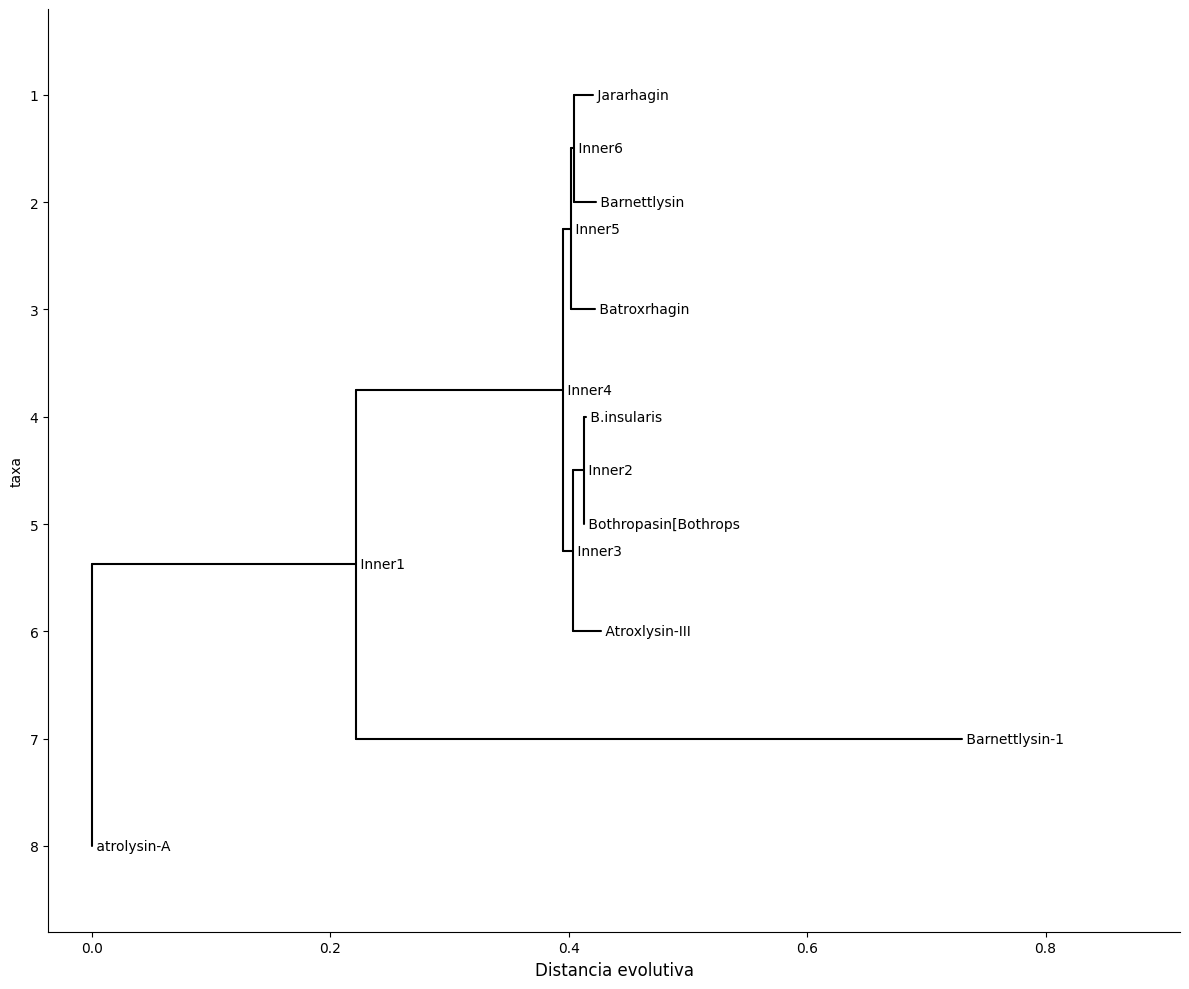

In [32]:

alineamiento = AlignIO.read(output_aln, "fasta")

calculadora = DistanceCalculator('identity')
matriz_distancias = calculadora.get_distance(alineamiento)

constructor = DistanceTreeConstructor(calculadora, 'nj')
arbol = constructor.build_tree(alineamiento)

arbol.root_with_outgroup("atrolysin-A")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(arbol, axes=ax, do_show=False)
ax.set_xlabel('Distancia evolutiva', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

Phylo.write(arbol, "arbol_filogenetico.nwk", "newick")

Visualización de las secuencias conservadas

(0.0, 1.0)

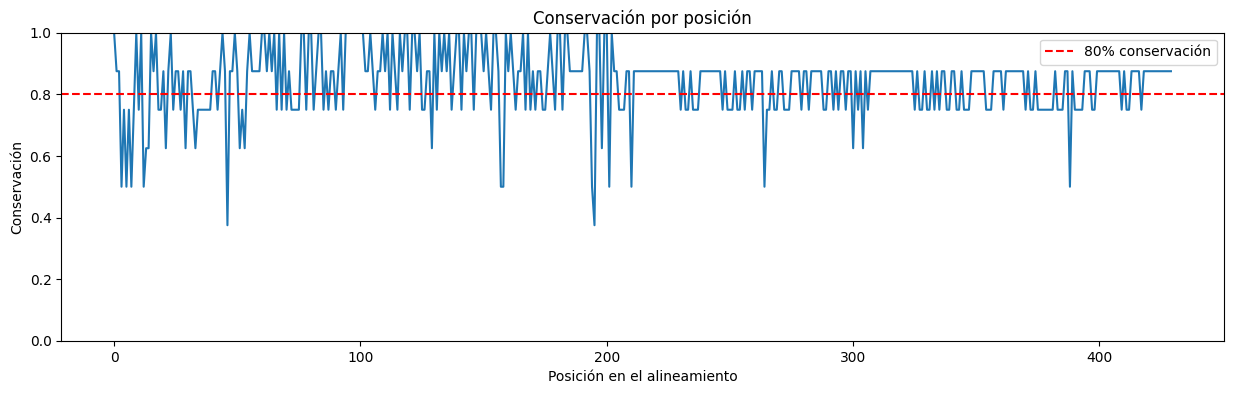

In [33]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt

output_aln = "alineamiento_muscle.aln"
alineamiento = AlignIO.read(output_aln, "fasta")

conservacion = []
for i in range(alineamiento.get_alignment_length()):
    columna = alineamiento[:, i]
    aa_mas_comun = max(set(columna), key=columna.count)
    frecuencia = columna.count(aa_mas_comun) / len(columna)
    conservacion.append(frecuencia)

plt.figure(figsize=(15, 4))
plt.plot(conservacion)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% conservación')
plt.xlabel('Posición en el alineamiento')
plt.ylabel('Conservación')
plt.title('Conservación por posición')
plt.legend()
plt.ylim(0, 1)

API de InterPro Scan

In [ ]:
import requests
import time
from Bio import SeqIO

secuencias = SeqIO.parse("Homologas Maduro Outgroup.fasta", "fasta")

for secuencia in secuencias:
    seq_str = str(secuencia.seq)

    url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
    params = {
        'email': 'jmantilla.symbiotech@gmail.com',
        'sequence': seq_str,
        'appl': 'Pfam,PANTHER,SMART'
    }

    response = requests.post(url, data=params)
    job_id = response.text

    print(f"Procesando: {secuencia.id}")

    status_url = f"https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status/{job_id}"
    while requests.get(status_url).text != 'FINISHED':
        time.sleep(10)

    result_url = f"https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/{job_id}/tsv"
    resultado = requests.get(result_url).text

    print(f"\nResultados para {secuencia.id}:")
    print(resultado)
    print("\n" + "="*50 + "\n")

Procesando: Atroxlysin-III
